In [1]:
import scanpy as sc
import pandas as pd
import numpy as np
import anndata
import scipy
import matplotlib.pyplot as plt
import seaborn as sns

import milopy.core as milo
import milopy.plot as milopl

In [2]:
import session_info
session_info.show()

In [3]:
## r2py setup
import anndata2ri
import rpy2.rinterface_lib.callbacks
import logging
rpy2.rinterface_lib.callbacks.logger.setLevel(logging.ERROR)

anndata2ri.activate()

In [8]:
sc.settings.set_figure_params(dpi=200)

# Read in

In [179]:
adata = sc.read_h5ad('/nfs/team205/heart/anndata_objects/Foetal/Immune/MoMP_Aug2023/MultiVI-post_foetal_Mono-MP_withContCov-CCCov_13Mar2023_feature-select-0003.h5ad')

# modify obs names
adata.obs_names = [x.replace('_paired','').replace('_expression','') for x in adata.obs_names]

# subset only macrophages
adata = adata[adata.obs['fine_grain_mod'].isin(['MacrophagesATF3pos',
                                                         'MacrophagesCX3CR1pos',
                                                         'MacrophagesLYVE1pos',
                                                         'MacrophagesTIMD4pos',
                                                         'MacrophagesYSderived',])]
adata

View of AnnData object with n_obs × n_vars = 6777 × 142283
    obs: 'sangerID', 'combinedID', 'donor', 'facility', 'cell_or_nuclei', 'modality', 'kit_10x', 'scrublet_score', 'doublet_pval', 'doublet_bh_pval', 'n_genes', 'n_counts', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'total_counts_mt', 'log1p_total_counts_mt', 'pct_counts_mt', 'total_counts_ribo', 'log1p_total_counts_ribo', 'pct_counts_ribo', 'HB_score', 'multiplexed', 'batch_key', 'region', 'FACSgate', 'sex', 'week', 'trimester', 'fine_grain', 'mid_grain', 'coarse_grain', 'heart_or_greatvessels', 'cycling', 'S_score', 'G2M_score', 'phase', 'stress_score', 'hb1_score', '_indices', '_scvi_batch', '_scvi_labels', 'fine_grain_withcycling', 't', 'seg', 'edge', 't_sd', 'milestones', 'fine_grain_mod'
    var: 'modality', 'gene_name_scRNA-0', 'gene_id', 'n_cells'
    uns: '_scvi_manager_uuid', '_scvi_uuid', 'adata_auc_gene', 'adata_auc_region', 'adata_gex', 'adata_gex_lognorm', 'adata_peak_tfi

In [180]:
adata.X.data[:10]

array([1., 1., 1., 2., 1., 1., 1., 2., 3., 1.], dtype=float32)

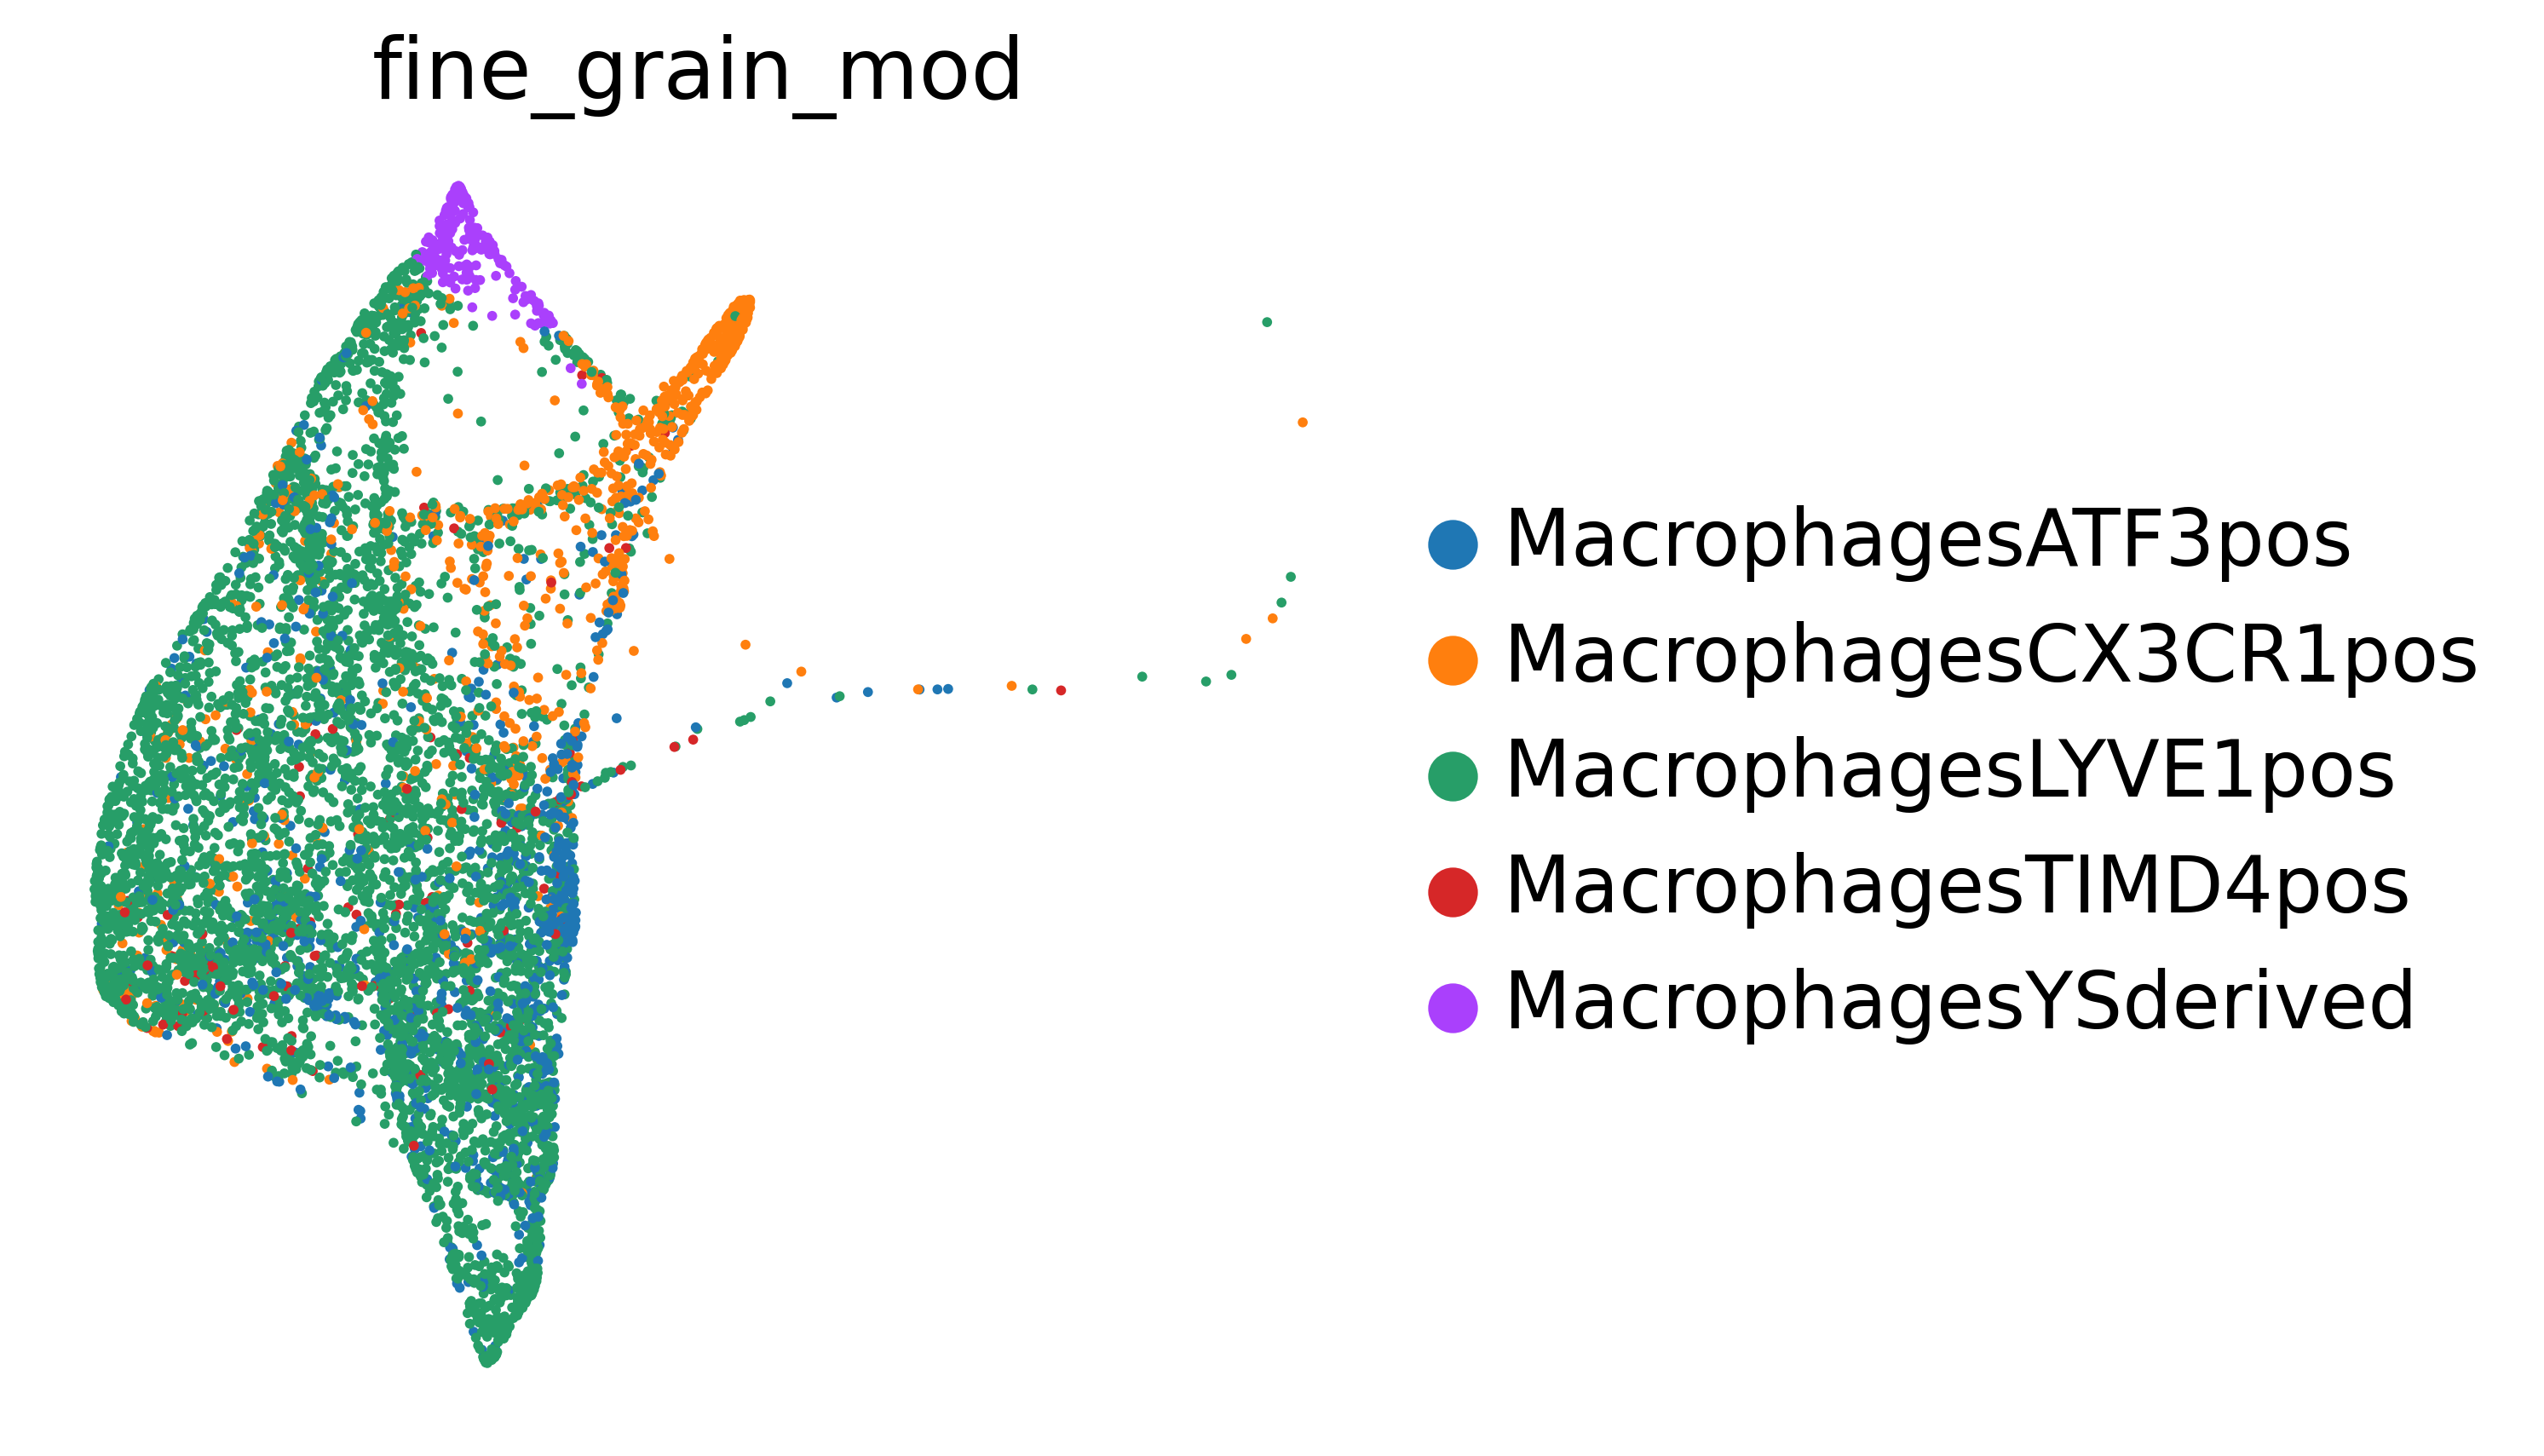

In [181]:
sc.pl.draw_graph(adata,color='fine_grain_mod', frameon=False)

/home/jovyan/my-conda-envs/cellpymc/lib/python3.7/site-packages/anndata/compat/_overloaded_dict.py:106: ImplicitModificationWarning: Trying to modify attribute `._uns` of view, initializing view as actual.
  self.data[key] = value


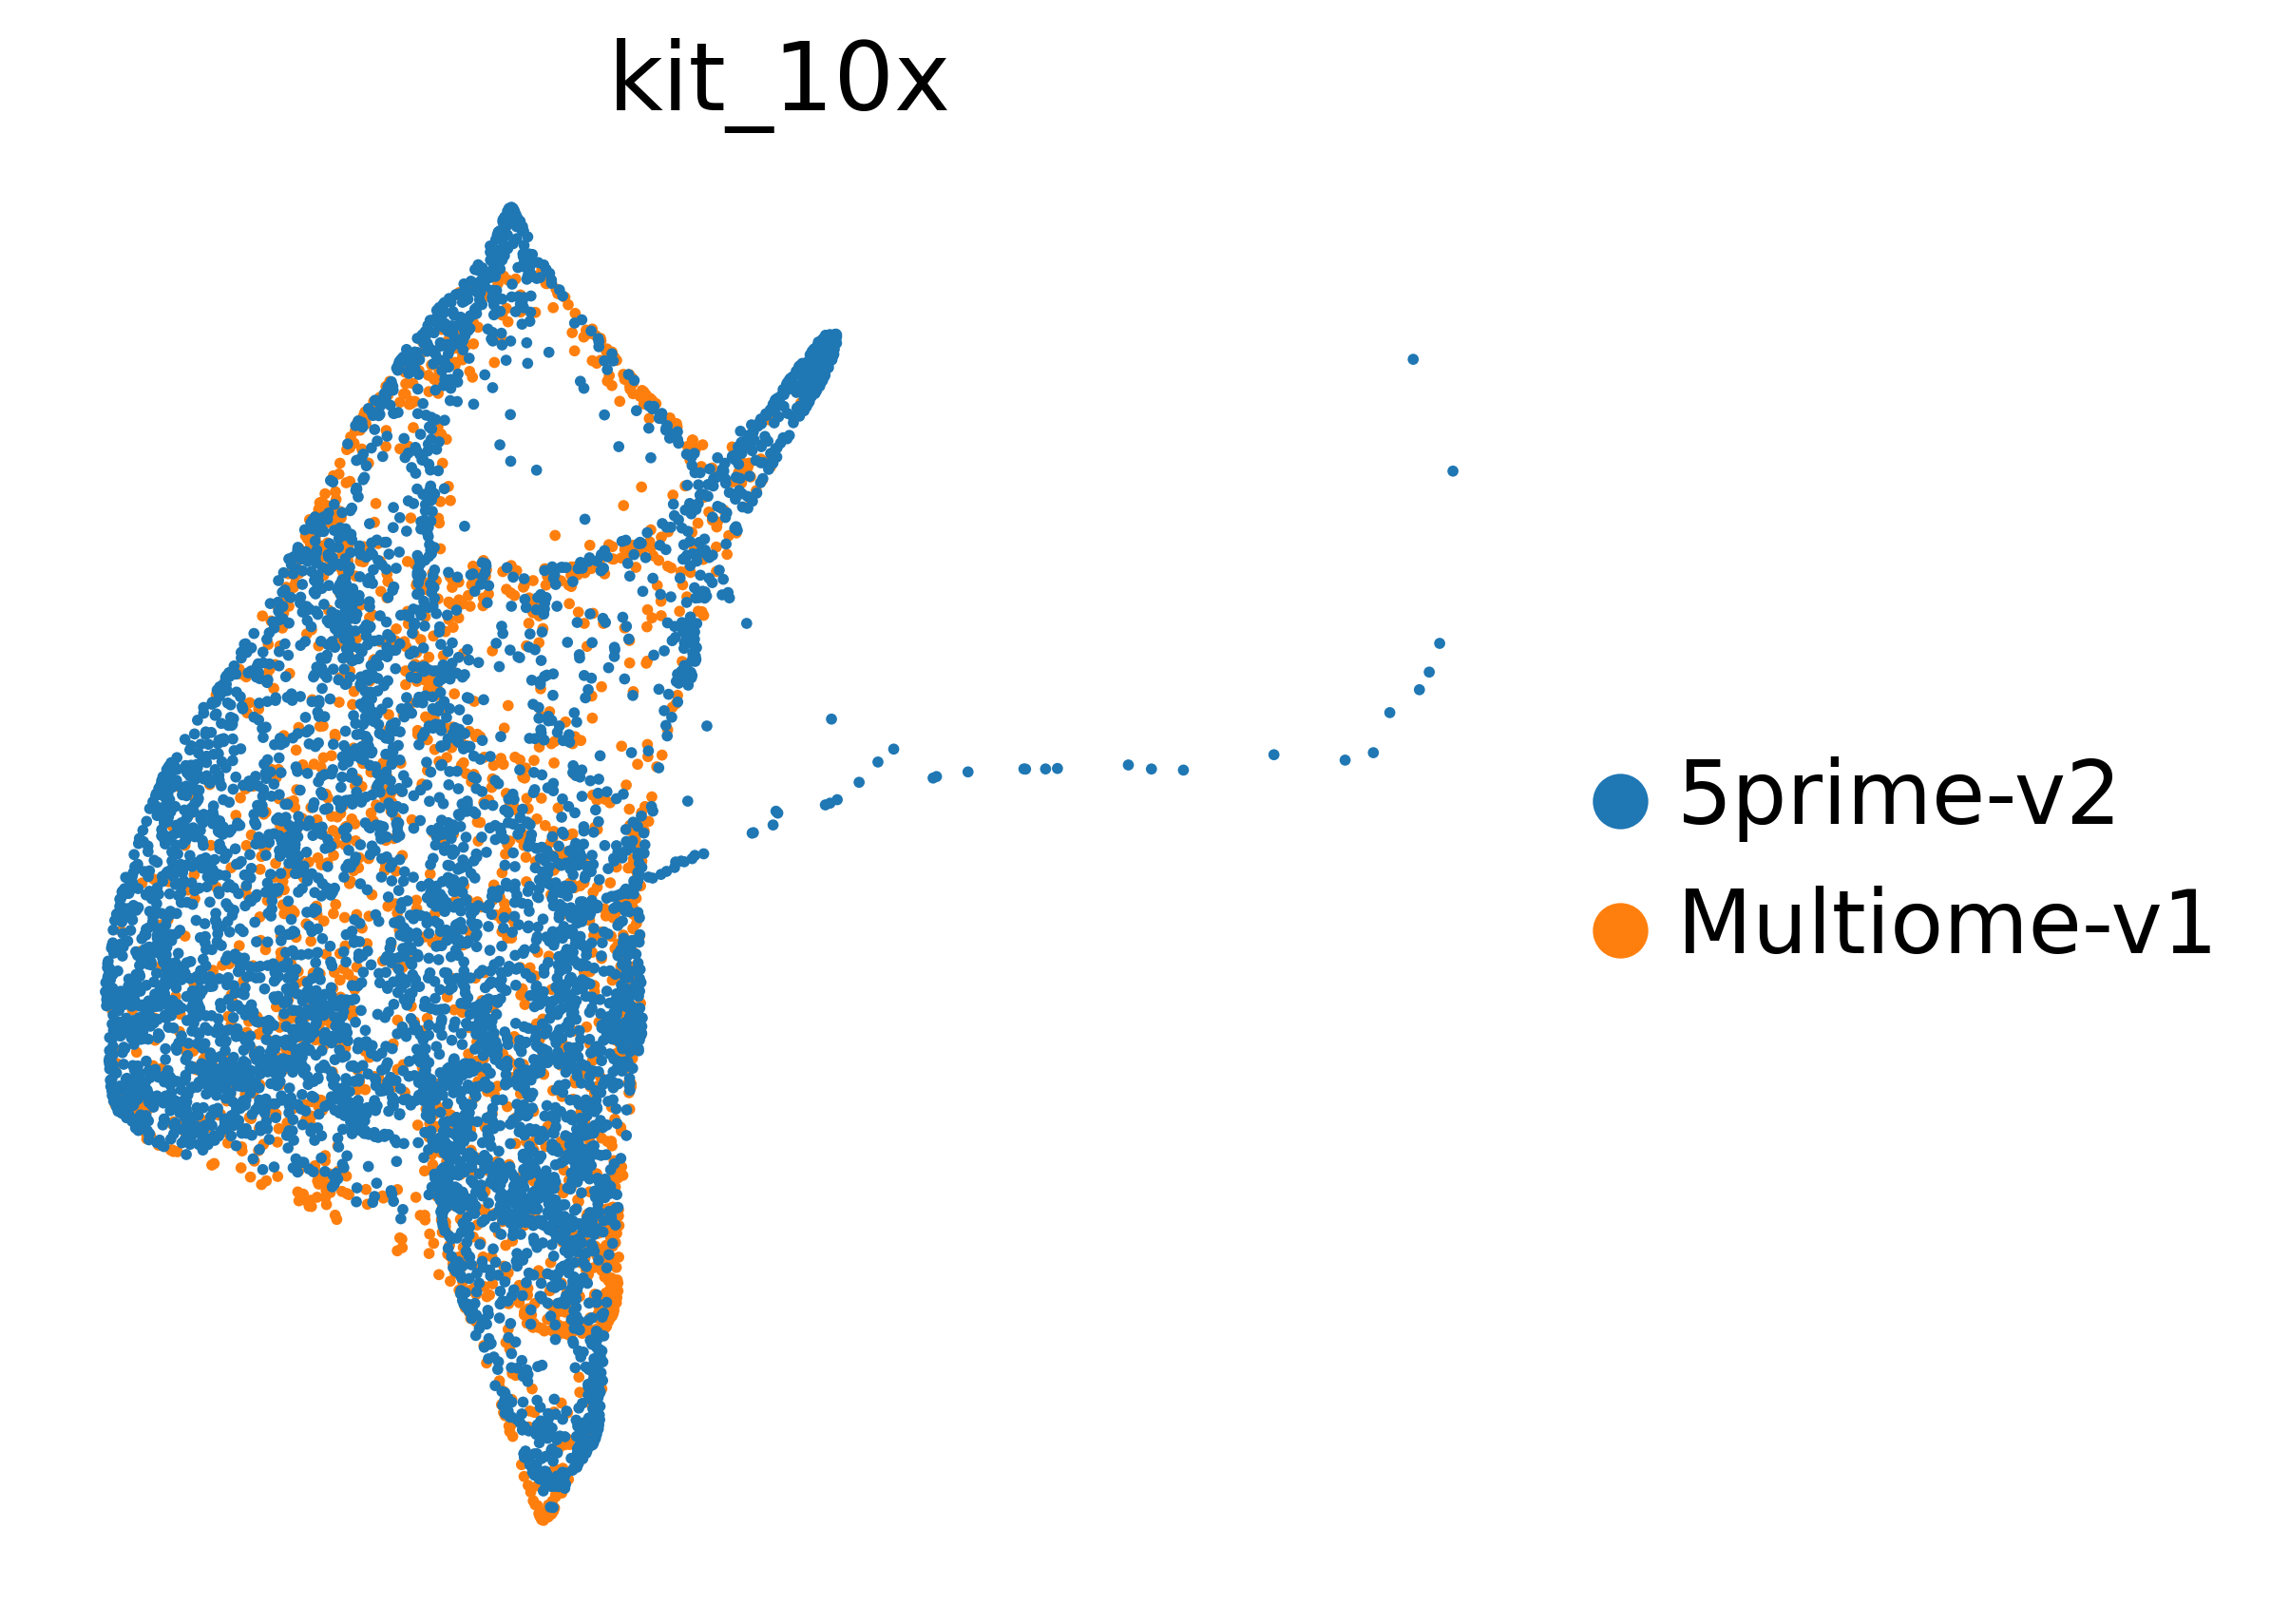

In [182]:
sc.pl.draw_graph(adata,color='kit_10x', frameon=False)

# Define neighbourhoods

In [183]:
%%time
## Recompute KNN graph
sc.pp.neighbors(adata, use_rep = "MultiVI_latent", n_neighbors = 50, key_added="multivi")

## Construct neighbourhoods
milo.make_nhoods(adata, neighbors_key="multivi", prop=0.05)

## Count cells in neighbourhoods
milo.count_nhoods(adata, sample_col="sangerID")

CPU times: user 3.43 s, sys: 7.29 s, total: 10.7 s
Wall time: 2.3 s


/home/jovyan/my-conda-envs/cellpymc/lib/python3.7/site-packages/anndata/_core/anndata.py:121: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)


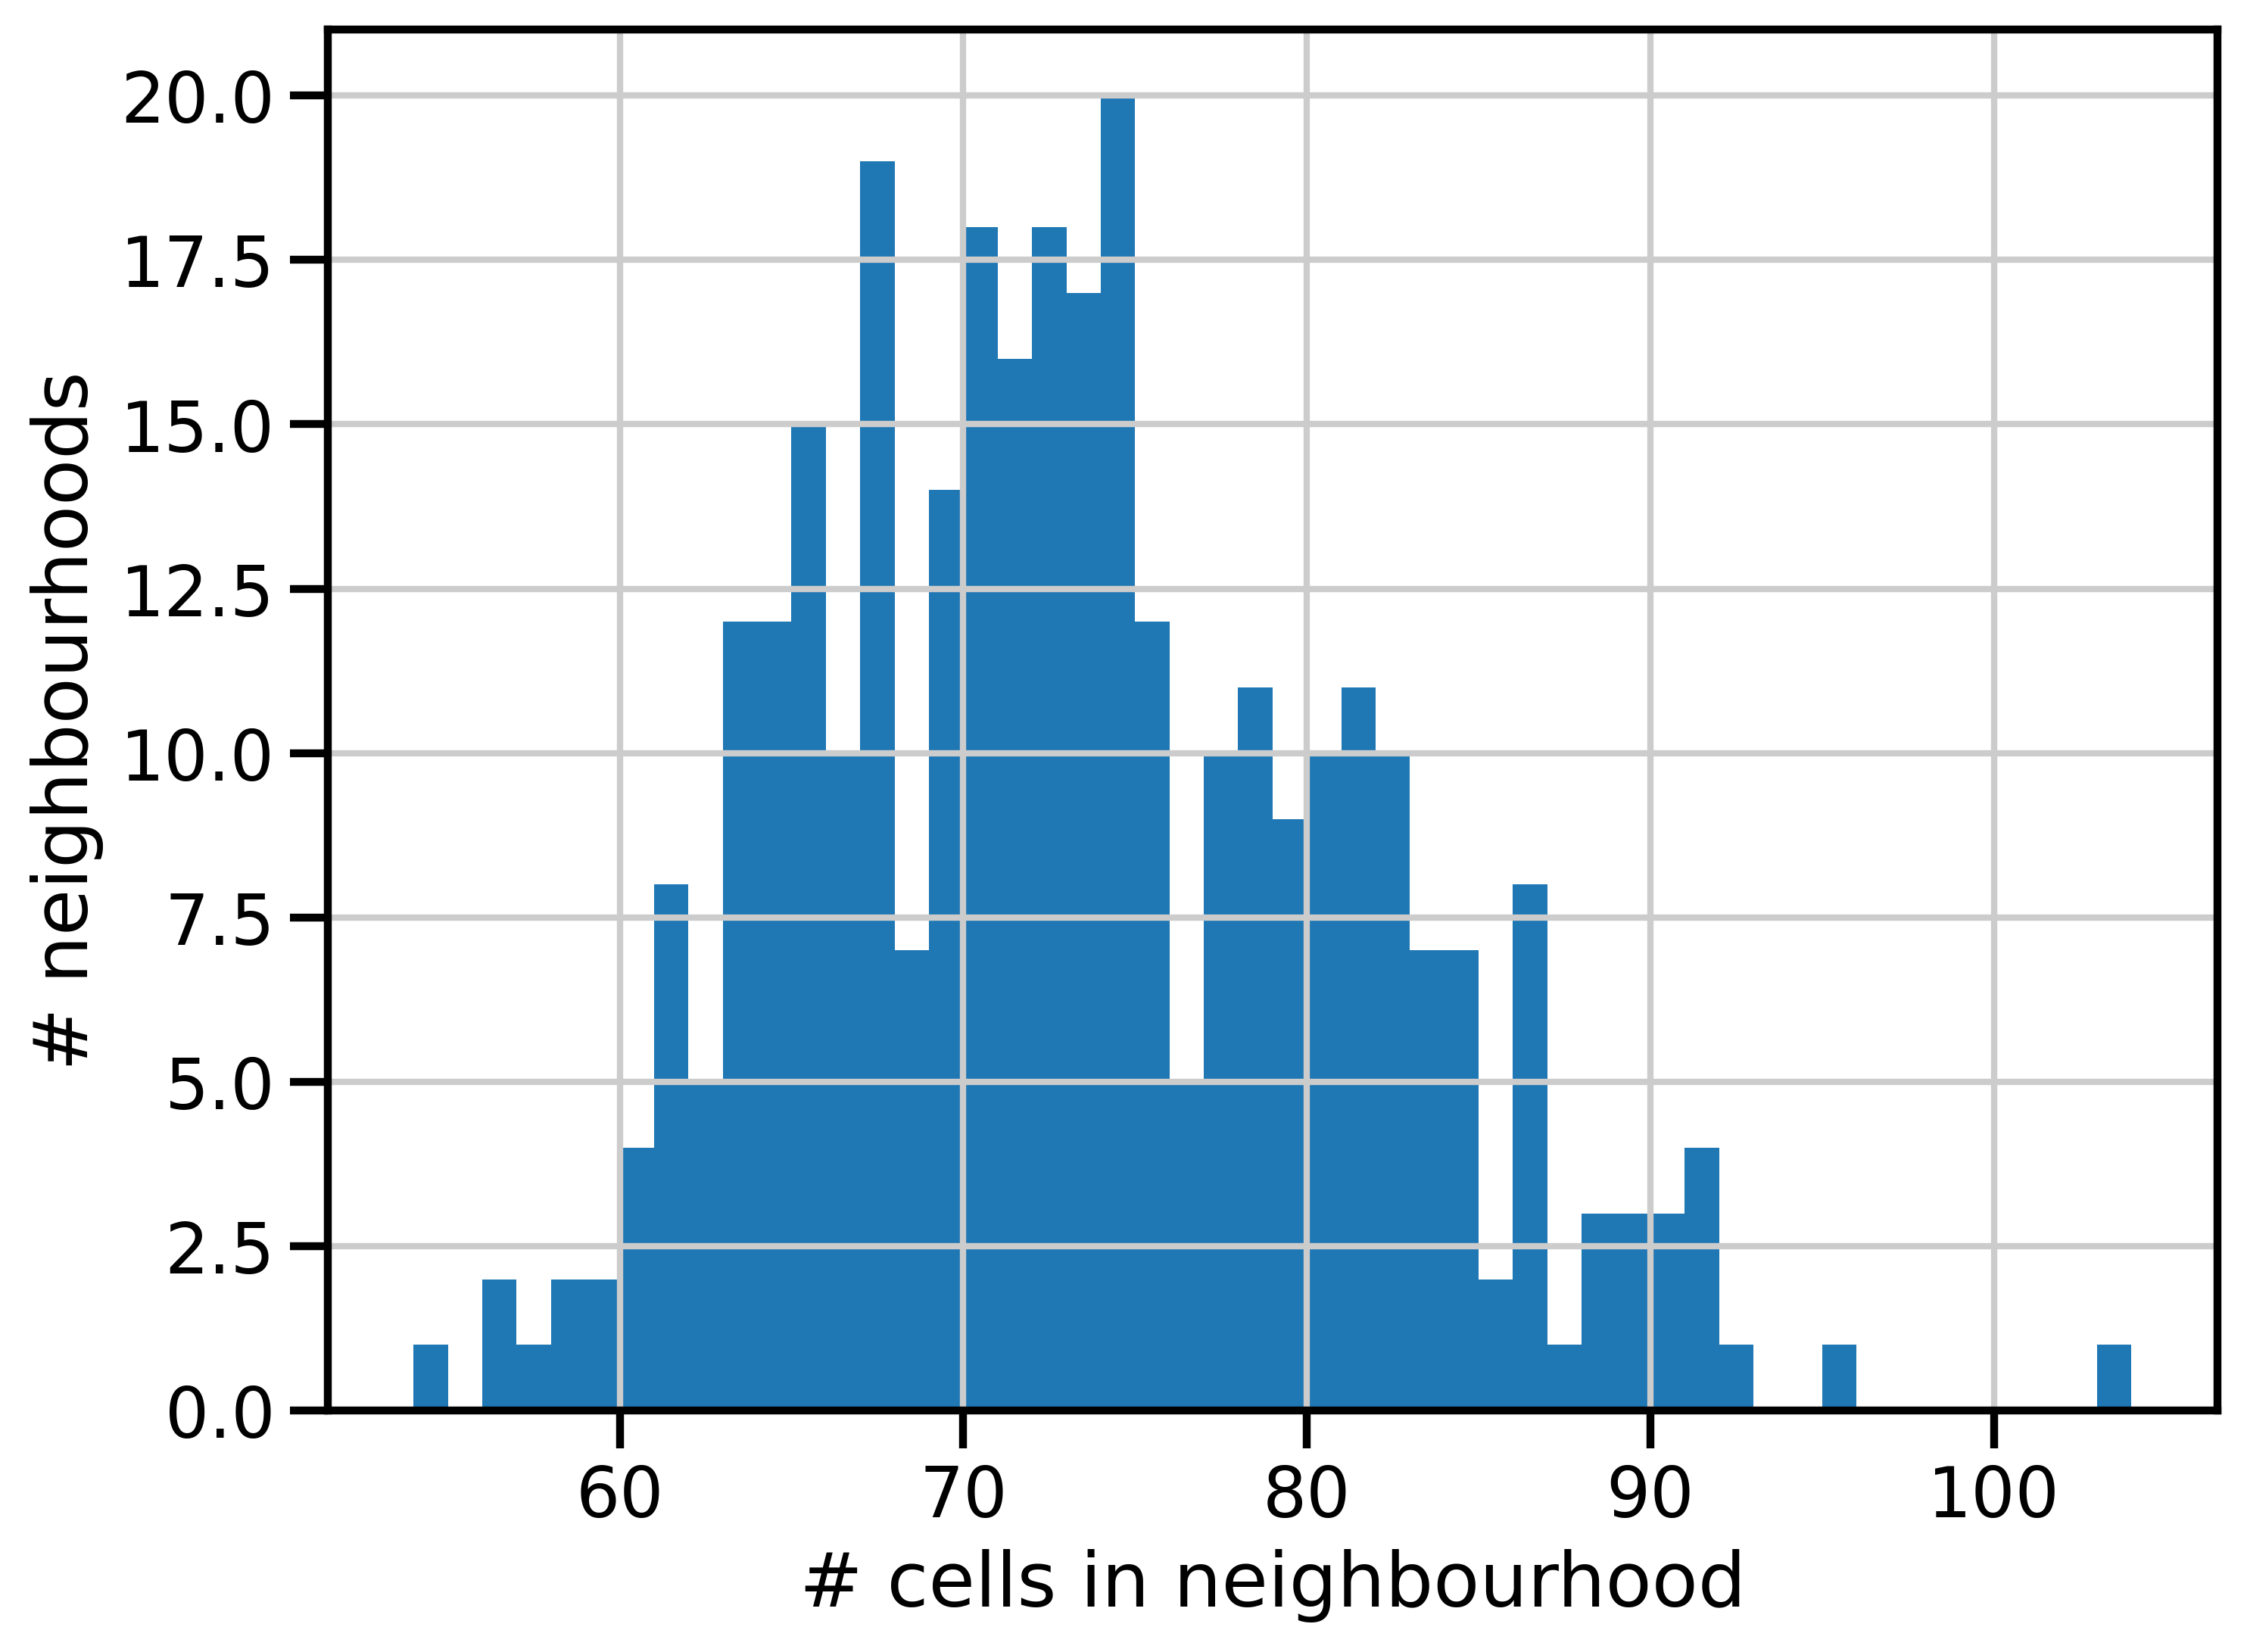

In [184]:
sns.set_context("talk")
plt.rcParams["figure.figsize"] = [8,6]
plt.hist(np.array(adata.obsm['nhoods'].sum(0)).ravel(), bins=50);
plt.xlabel('# cells in neighbourhood'); plt.ylabel('# neighbourhoods');
# plt.savefig(figdir+'nhood_size_hist.pdf',bbox_inches='tight');

In [185]:
adata.uns["nhood_adata"]

AnnData object with n_obs × n_vars = 322 × 21
    obs: 'index_cell', 'kth_distance'
    uns: 'sample_col'

# Differential abundance testing with GLM

In [186]:
adata.obs["week_continuous"] = [int(x.split('W')[0]) for x in adata.obs["week"]] #rather than adata.obs["week"].cat.codes
pd.crosstab(adata.obs['week_continuous'],adata.obs['week'])

week,5W,7W,8W,9W,10W,12W,13W
week_continuous,,,,,,,
5,406,0,0,0,0,0,0
7,0,1146,0,0,0,0,0
8,0,0,3729,0,0,0,0
9,0,0,0,127,0,0,0
10,0,0,0,0,478,0,0
12,0,0,0,0,0,112,0
13,0,0,0,0,0,0,779


In [187]:
milo.DA_nhoods(adata, design="~ week_continuous")

/home/jovyan/my-conda-envs/cellpymc/lib/python3.7/site-packages/rpy2/robjects/vectors.py:980: UserWarning: R object inheriting from "POSIXct" but without attribute "tzone".
  warnings.warn('R object inheriting from "POSIXct" but without '
/home/jovyan/my-conda-envs/cellpymc/lib/python3.7/site-packages/milopy/core.py:285: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  nhood_adata.obs = pd.concat([nhood_adata.obs, res], 1)


In [188]:
import milopy.utils
milopy.utils.build_nhood_graph(adata,basis='X_draw_graph_fa')

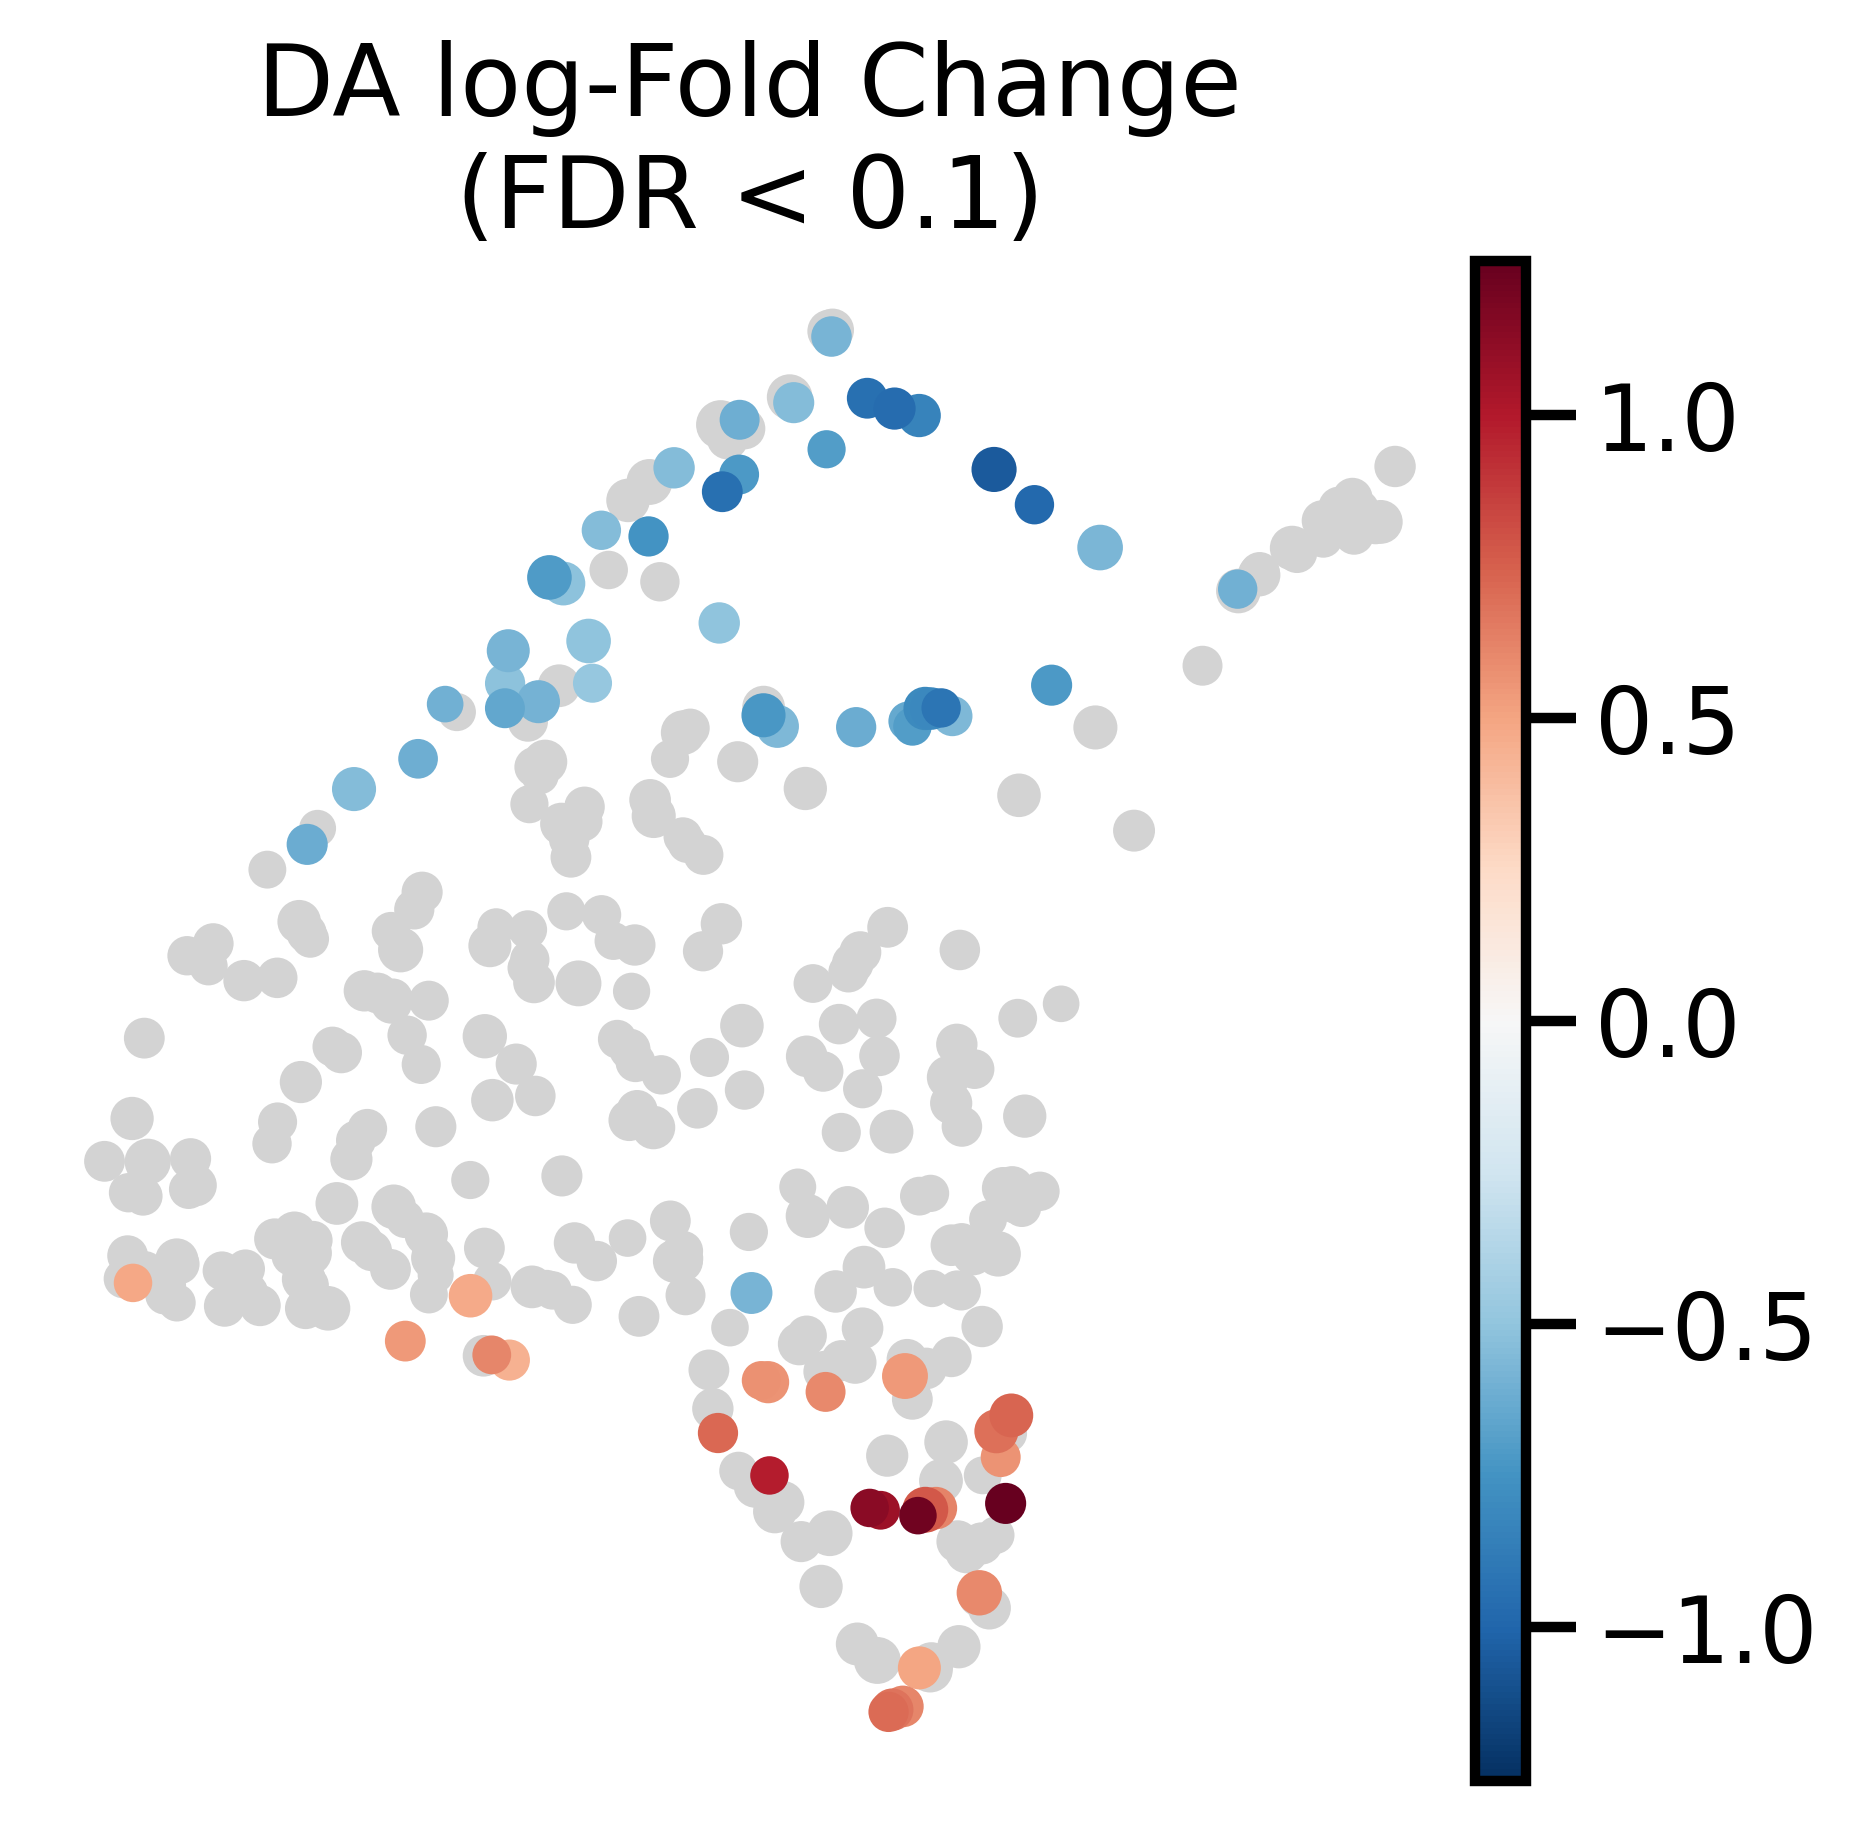

In [189]:
plt.rcParams["figure.figsize"] = [5,5]
milopl.plot_nhood_graph(adata, 
                        alpha=0.1, ## SpatialFDR level (1%) 
                        min_size=3, ## Size of smallest dot
                        title = 'DA log-Fold Change\n(FDR < 0.1)'
                       )

In [190]:
milopy.utils.annotate_nhoods(adata, anno_col='fine_grain_mod')

In [191]:
da_results = adata.uns['nhood_adata'].obs.copy()
# drop nan
da_results.dropna(axis=0,inplace=True)
# reindex
da_results.index = list(range(len(da_results)))
# add 'Nhood' column
da_results['Nhood'] = da_results.index.astype('int')+1 
da_results['Nhood'] = da_results['Nhood'].astype('str')

da_results

,index_cell,kth_distance,logFC,logCPM,F,PValue,FDR,SpatialFDR,Nhood_size,nhood_annotation,nhood_annotation_frac,Nhood
0,BHF_F_Hea11933670_BHF_F_Hea11596623_GATTGATGTT...,1.456107,-0.485475,13.406910,6.165901,1.305019e-02,7.372215e-02,7.966068e-02,65.0,MacrophagesLYVE1pos,0.923077,1
1,BHF_F_Hea11933668_BHF_F_Hea11596621_GCCAGGTTCA...,2.753402,1.128974,13.873881,35.805067,2.304259e-09,2.473238e-07,4.691488e-07,77.0,MacrophagesLYVE1pos,0.610390,2
2,7089STDY13216927_BHF_F_Hea13242534_CACCTGTTCCC...,1.462260,0.386658,13.734428,4.126973,4.224791e-02,1.581840e-01,1.639379e-01,73.0,MacrophagesLYVE1pos,0.972603,3
3,BHF_F_Hea11933667_BHF_F_Hea11596620_GTTGGAGCAA...,1.732683,0.725002,13.793573,17.435932,3.012828e-05,6.929505e-04,9.498297e-04,89.0,MacrophagesLYVE1pos,0.651685,4
4,BHF_F_Hea11933668_BHF_F_Hea11596621_TCGCGAGGTG...,1.725373,0.247964,13.223796,1.731931,1.882138e-01,3.987162e-01,4.042951e-01,76.0,MacrophagesLYVE1pos,0.947368,5
...,...,...,...,...,...,...,...,...,...,...,...,...
317,BHF_F_Hea11192327_AGTGAGGTCGGATGGA-1,1.216661,-0.179132,13.499258,0.635023,4.255497e-01,5.983712e-01,6.110943e-01,88.0,MacrophagesLYVE1pos,0.920455,318
318,BHF_F_Hea11192327_CACCAGGGTGTATGGG-1,1.443326,0.343498,12.931260,2.536134,1.113186e-01,2.989581e-01,3.042321e-01,65.0,MacrophagesLYVE1pos,0.892308,319
319,BHF_F_Hea11192327_TGGGCGTCACATGACT-1,2.183647,0.256078,12.969056,1.297777,2.546643e-01,4.423045e-01,4.525665e-01,64.0,MacrophagesLYVE1pos,0.593750,320
320,BHF_F_Hea11192327_GGACATTAGTAATCCC-1,1.809691,-0.039152,13.015973,0.031230,8.597335e-01,9.098354e-01,9.115281e-01,61.0,MacrophagesLYVE1pos,0.786885,321


Text(0.5, 0, 'celltype fraction')

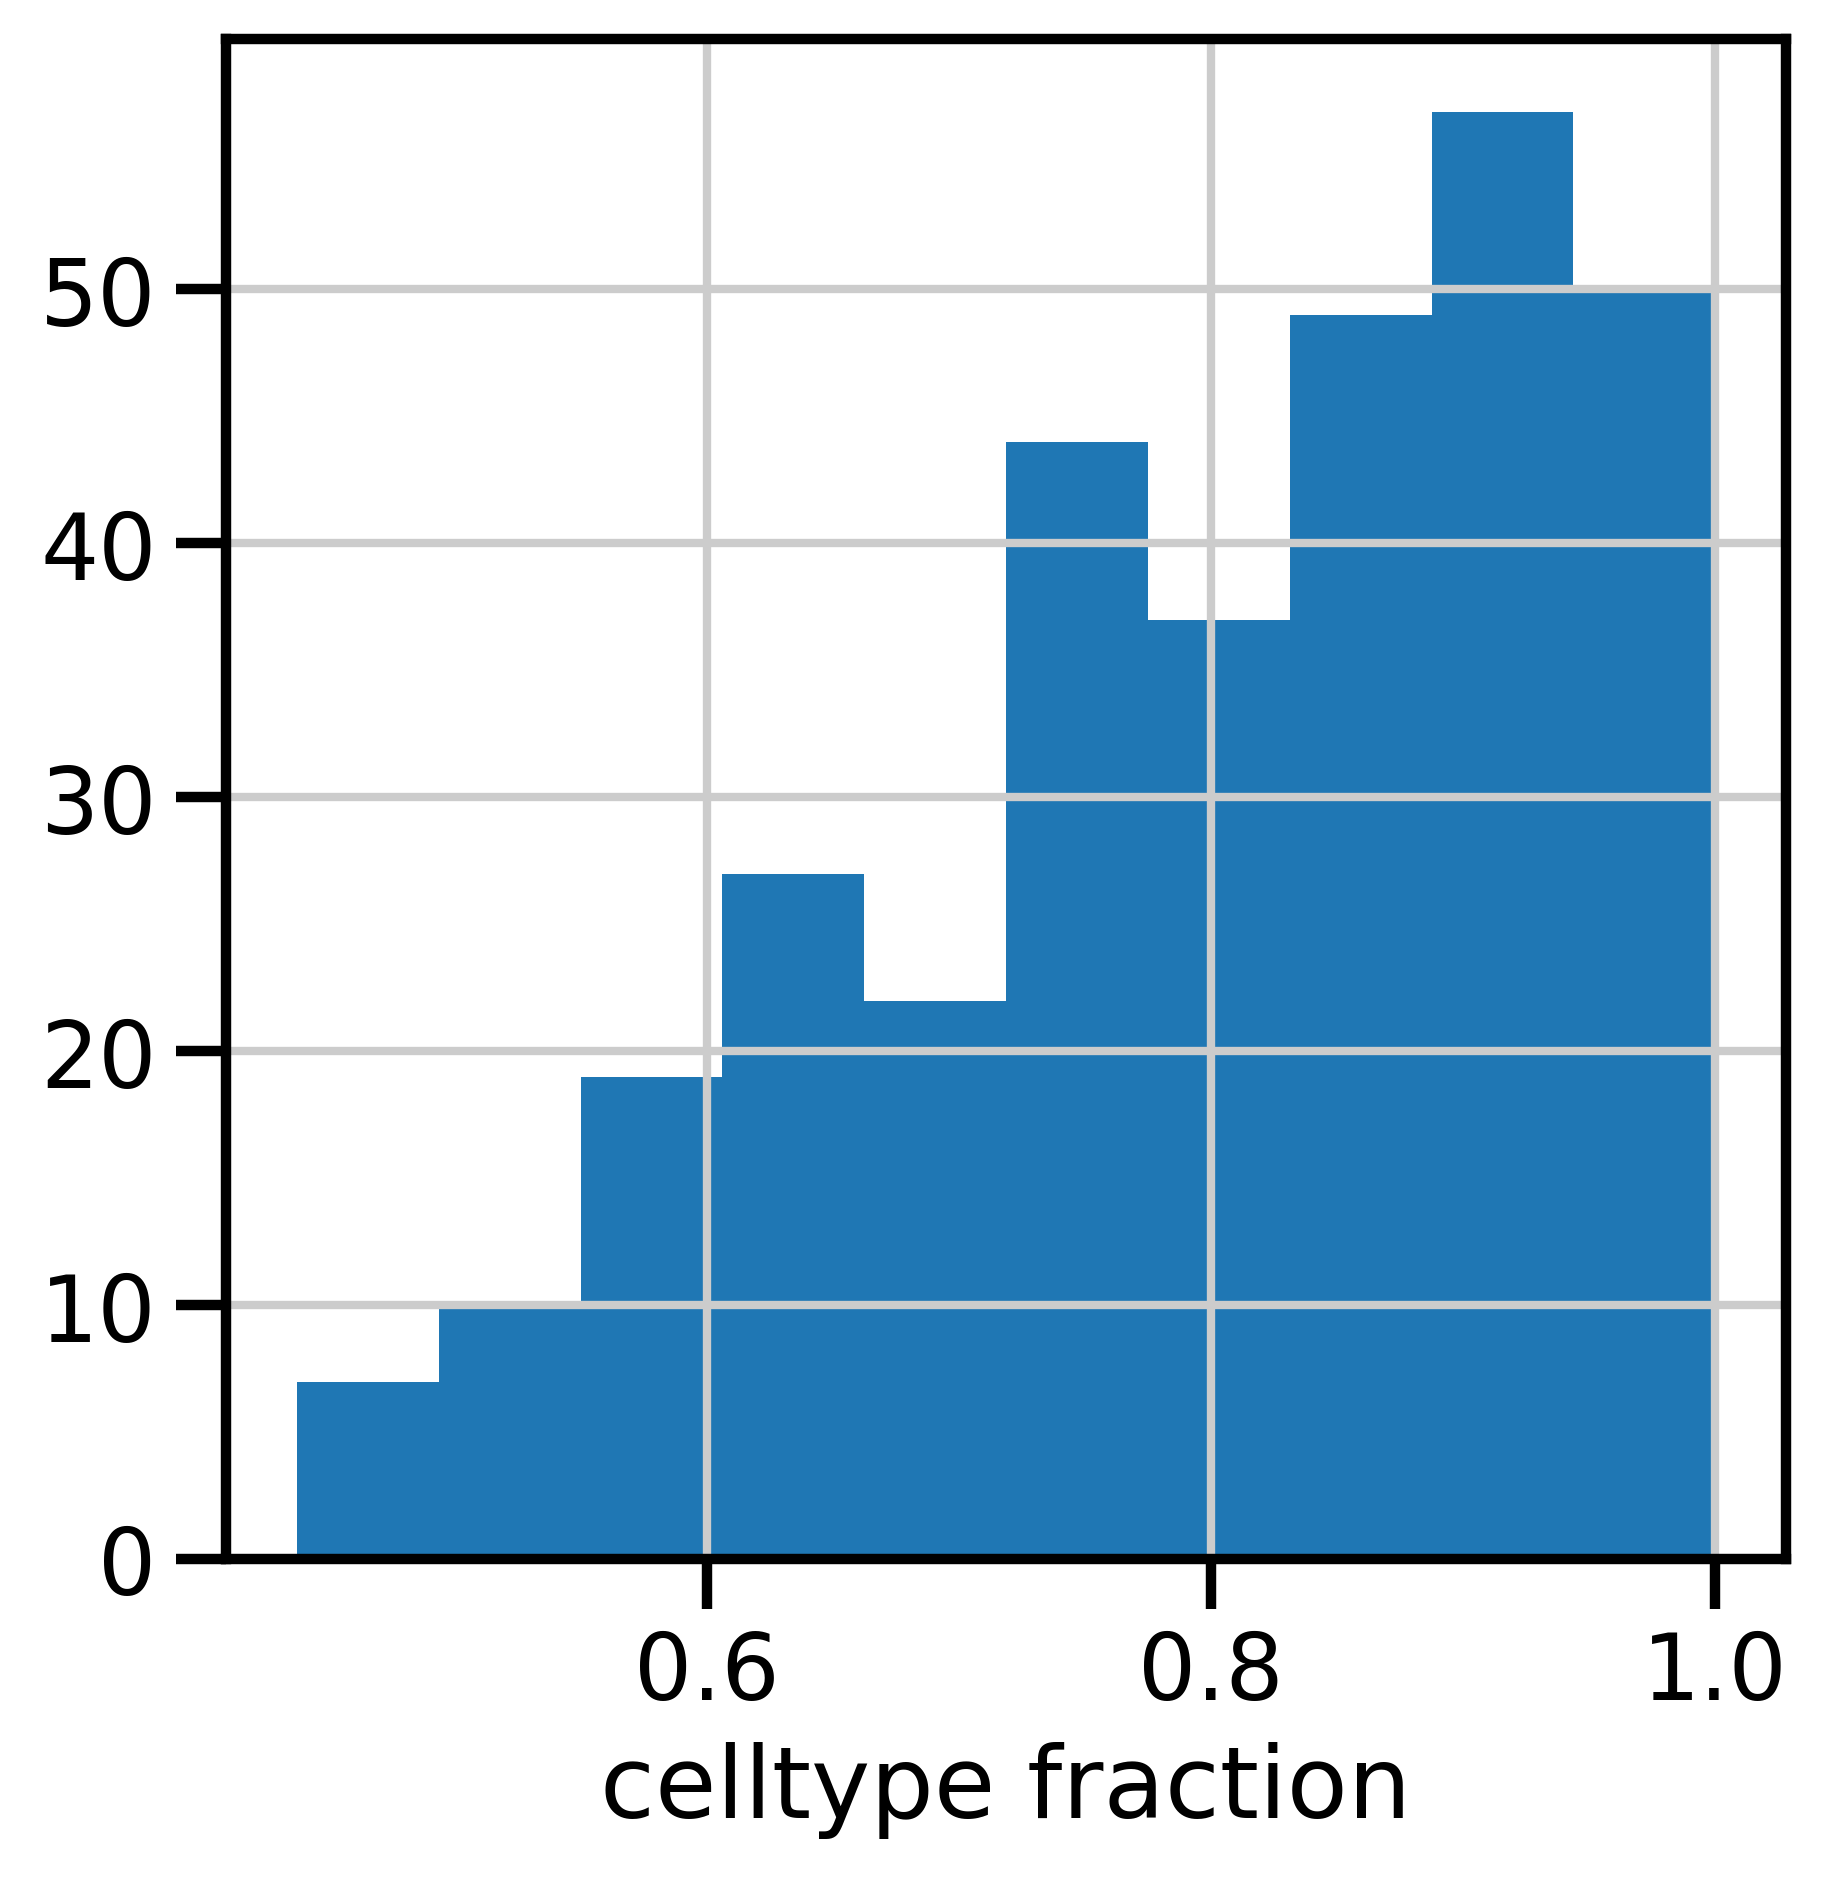

In [192]:
plt.hist(adata.uns['nhood_adata'].obs["nhood_annotation_frac"]);
plt.xlabel("celltype fraction")

In [193]:
%load_ext rpy2.ipython

The rpy2.ipython extension is already loaded. To reload it, use:
  %reload_ext rpy2.ipython


In [194]:
%%R
library(miloR)
library(tidyverse)
library(ggbeeswarm)

# modifying color scale
plotDAbeeswarm_mod <- function(da.res, group.by=NULL, alpha=0.1, subset.nhoods=NULL){
  if (!is.null(group.by)) {
    if (!group.by %in% colnames(da.res)) {
      stop(group.by, " is not a column in da.res. Have you forgot to run annotateNhoods(x, da.res, ", group.by,")?")
    }
    if (is.numeric(da.res[,group.by])) {
      # stop(group.by, " is a numeric variable. Please bin to use for grouping.")
    }
    da.res <- mutate(da.res, group_by = da.res[,group.by])
  } else {
    da.res <- mutate(da.res, group_by = "g1")
  }

  if (!is.factor(da.res[,"group_by"])) {
    message("Converting group_by to factor...")
    da.res <- mutate(da.res, group_by = factor(group_by, levels=unique(group_by)))
    # anno_vec <- factor(anno_vec, levels=unique(anno_vec))
  }

  if (!is.null(subset.nhoods)) {
    da.res <- da.res[subset.nhoods,]
  }
  
  # Get position with ggbeeswarm
  beeswarm_pos <- ggplot_build(
    da.res %>%
      mutate(is_signif = ifelse(SpatialFDR < alpha, 1, 0)) %>%
      arrange(group_by) %>%
      ggplot(aes(group_by, logFC)) +
      geom_quasirandom()
  )
  
  pos_x <- beeswarm_pos$data[[1]]$x
  pos_y <- beeswarm_pos$data[[1]]$y
  
  n_groups <- unique(da.res$group_by) %>% length()
  
  da.res %>%
    mutate(is_signif = ifelse(SpatialFDR < alpha, 1, 0)) %>%
    mutate(logFC_color = ifelse(is_signif==1, logFC, NA)) %>%
    arrange(group_by) %>%
    mutate(Nhood=factor(Nhood, levels=unique(Nhood))) %>%
    mutate(pos_x = pos_x, pos_y=pos_y) %>%
    ggplot(aes(pos_x, pos_y, color=logFC_color)) +
    scale_color_gradient2(low = "blue",high = "red") +
    guides(color="none") +
    xlab(group.by) + ylab("Log Fold Change") +
    scale_x_continuous(
      breaks = seq(1,n_groups),
      labels = setNames(levels(da.res$group_by), seq(1,n_groups))
      ) +
    geom_point() +
    coord_flip() +
    theme_bw(base_size=22) +
    theme(strip.text.y =  element_text(angle=0))

}


In [195]:
%%R
head(da_results)

                                              index_cell kth_distance
1 BHF_F_Hea11933670_BHF_F_Hea11596623_GATTGATGTTGAGCCG-1     1.456107
2 BHF_F_Hea11933668_BHF_F_Hea11596621_GCCAGGTTCACCGGTA-1     2.753402
3  7089STDY13216927_BHF_F_Hea13242534_CACCTGTTCCCGAAGC-1     1.462260
4 BHF_F_Hea11933667_BHF_F_Hea11596620_GTTGGAGCAACAGGAT-1     1.732683
5 BHF_F_Hea11933668_BHF_F_Hea11596621_TCGCGAGGTGTTTCAC-1     1.725373
6 BHF_F_Hea11933667_BHF_F_Hea11596620_GTGAGGAGTTGTTCAC-1     1.519573
       logFC   logCPM         F       PValue          FDR   SpatialFDR
1 -0.4854753 13.40691  6.165901 1.305019e-02 7.372215e-02 7.966068e-02
2  1.1289741 13.87388 35.805067 2.304259e-09 2.473238e-07 4.691488e-07
3  0.3866579 13.73443  4.126973 4.224791e-02 1.581840e-01 1.639379e-01
4  0.7250017 13.79357 17.435932 3.012828e-05 6.929505e-04 9.498297e-04
5  0.2479639 13.22380  1.731931 1.882138e-01 3.987162e-01 4.042951e-01
6  0.3353341 13.20775  2.624008 1.053098e-01 2.969872e-01 3.030582e-01
  Nhood_size 

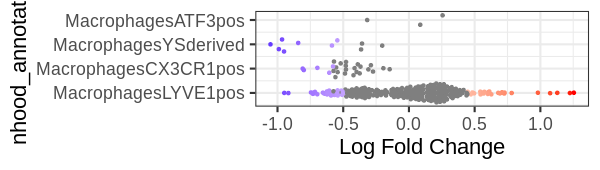

In [196]:
%%R -i da_results -w 600 -h 170
# da_results = da_results %>% filter(nhood_annotation %in% c(Monocytes))
plotDAbeeswarm_mod(da_results, group.by = "nhood_annotation")